In [11]:
import pandas as pd
from lxml import html
from pydantic import BaseModel
from typing import Any, Optional
from unstructured.partition.pdf import partition_pdf

# Use Case

Many documents contain a mixture of content types, including text, images, and tables. 

* `Semi-structured data`: RAG on text and tables has remained a challenge
* `Image`: images often contain valuable information that are excluded from RAG due to model limitations

Here, we show how Unstructured can be used to partition all semi-structured data from documents. 

And, we show RAG on semi-structured data.

In a follow-up notebook, we show how this can be extended to images.

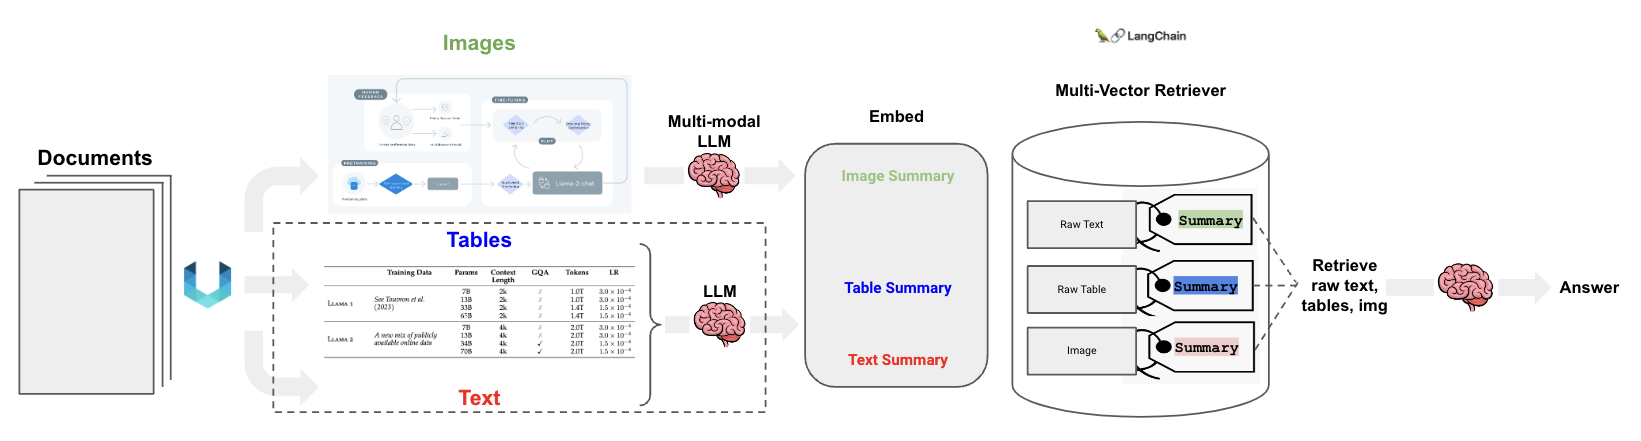

## Data Loading

### Partition PDF tables and text w/ Unstructured
  
* `LLaMA2` Paper: https://arxiv.org/pdf/2307.09288.pdf
* Use `chunking_strategy="by_title"`, which rolls up subsequent non-Table elements under a Title into a `CompositeElement`
* Unstructured uses a [table recognition module](https://unstructured-io.github.io/unstructured/introduction.html#tables).

In [12]:
# Get elements
raw_pdf_elements = partition_pdf(filename="/Users/rlm/Desktop/Papers/2307.09288.pdf",
                                 # Using pdf format to find embedded image blocks
                                 extract_images_in_pdf=False,
                                 # Use layout model (YOLO-X) to get bounding boxes (for tables) and find titles
                                 # Titles are any sub-section of the document 
                                 infer_table_structure=True, 
                                 # Post processing to aggregate text once we have the title 
                                 chunking_strategy="by_title",
                                 # Chunking params to aggregate text blocks
                                 # Attempt to create a new chunk 3800 chars
                                 # Attempt to keep chunks > 2000 chars 
                                 # Hard max on chunks
                                 max_characters=4000, 
                                 new_after_n_chars=3800, 
                                 combine_text_under_n_chars=2000,
                                 image_output_dir_path=path)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 184,
 "<class 'unstructured.documents.elements.Table'>": 47,
 "<class 'unstructured.documents.elements.TableChunk'>": 2}

In [14]:
class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

49
184


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

### Summaries

In [16]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [17]:
# Prompt 
prompt_text="""You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text) 

# Summary chain 
model = ChatOpenAI(temperature=0,model="gpt-4")
summarize_chain = {"element": lambda x:x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [26]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

In [27]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s,metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

In [28]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatOpenAI(temperature=0,model="gpt-4")

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()} 
    | prompt 
    | model 
    | StrOutputParser()
)

In [29]:
chain.invoke("What is the number of training tokens for LLaMA2?")

'The number of training tokens for LLaMA2 is 2.0T.'

We can check the [trace](https://smith.langchain.com/public/4739ae7c-1a13-406d-bc4e-3462670ebc01/r) to see what chunks were retrieved:

This includes Table 1 of the paper, showing the Tokens used for training.

```
Training Data Params Context GQA Tokens LR Length 7B 2k 1.0T 3.0x 10-4 See Touvron et al. 13B 2k 1.0T 3.0 x 10-4 LiaMa 1 (2023) 33B 2k 14T 1.5 x 10-4 65B 2k 1.4T 1.5 x 10-4 7B 4k 2.0T 3.0x 10-4 Liama 2 A new mix of publicly 13B 4k 2.0T 3.0 x 10-4 available online data 34B 4k v 2.0T 1.5 x 10-4 70B 4k v 2.0T 1.5 x 10-4
```